In [1]:
import re

import numpy as np
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split

In [8]:
# Exemple de données simplifiées : on va récupérer un dataset textuel basique
# Ici on utilise 2 catégories du dataset 20 newsgroups comme "sentiments"
categories = ["rec.sport.hockey", "sci.space"]
data = fetch_20newsgroups(subset="all", categories=categories)

# Texte et labels
texts = data.data
labels = data.target


# Simple fonction de nettoyage basique
def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+", "", text)  # enlever URLs
    text = re.sub(r"\W+", " ", text)  # garder que lettres/chiffres
    text = re.sub(r"\d+", "", text)  # enlever chiffres
    return text.strip()


texts_cleaned = [clean_text(t) for t in texts]

# Split train/test
X_train, X_test, y_train, y_test = train_test_split(
    texts_cleaned, labels, test_size=0.2, random_state=42
)

# TF-IDF Vectorizer
vectorizer = TfidfVectorizer(max_features=100, ngram_range=(1, 2))
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Modèle simple : Logistic Regression
model = LogisticRegression(max_iter=1000)
model.fit(X_train_tfidf, y_train)

# Prédictions
y_pred = model.predict(X_test_tfidf)

# Évaluation
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=categories))

Accuracy: 0.9195979899497487
                  precision    recall  f1-score   support

rec.sport.hockey       0.96      0.88      0.92       202
       sci.space       0.88      0.96      0.92       196

        accuracy                           0.92       398
       macro avg       0.92      0.92      0.92       398
    weighted avg       0.92      0.92      0.92       398



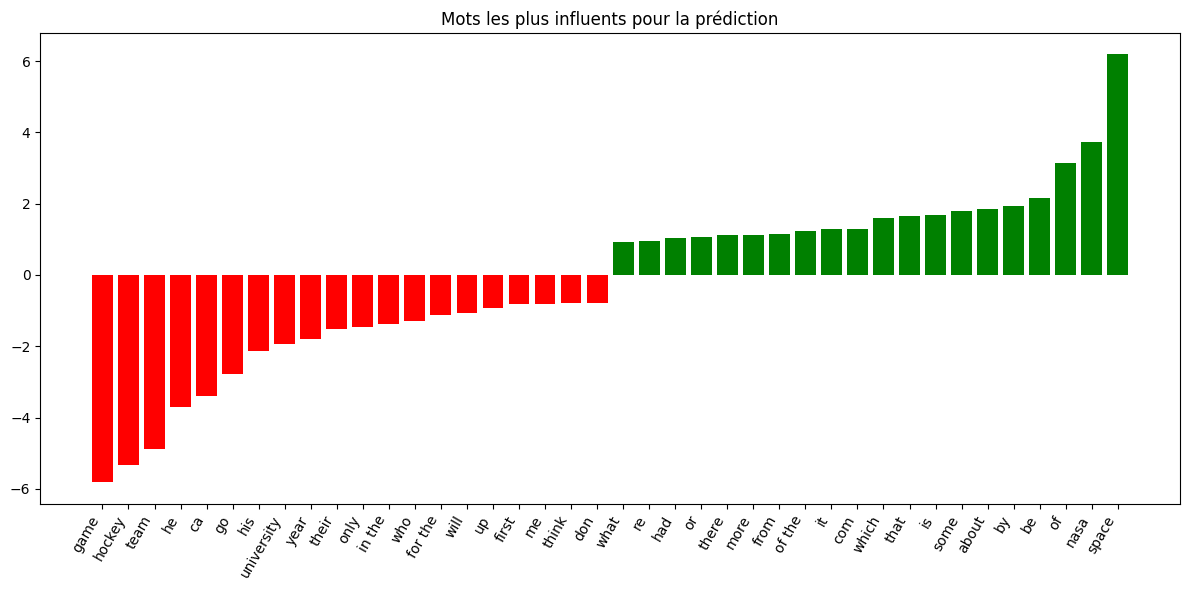

In [9]:
import matplotlib.pyplot as plt

# Récupérer les poids du modèle
feature_names = vectorizer.get_feature_names_out()
coefs = model.coef_[0]

# Trier les mots les plus influents
top_n = 20

top_positive_coefficients = np.argsort(coefs)[-top_n:]
top_negative_coefficients = np.argsort(coefs)[:top_n]

# Afficher les poids dans un seul plot
top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
colors = ["red" if c < 0 else "green" for c in coefs[top_coefficients]]

plt.figure(figsize=(12, 6))
plt.bar(np.arange(2 * top_n), coefs[top_coefficients], color=colors)
plt.xticks(
    np.arange(2 * top_n),
    np.array(feature_names)[top_coefficients],
    rotation=60,
    ha="right",
)
plt.title("Mots les plus influents pour la prédiction")
plt.tight_layout()
plt.show()

In [15]:
def explain_prediction(text, vectorizer, model, feature_names, top_n=10):
    # Nettoyage
    cleaned = clean_text(text)

    # Vectorisation
    X = vectorizer.transform([cleaned])

    # Récupération des mots présents
    indices = X.nonzero()[1]
    word_weights = model.coef_[0][indices]
    words = np.array(feature_names)[indices]

    # Tri des mots selon leur contribution
    sorted_idx = np.argsort(np.abs(word_weights))[::-1]
    top_words = words[sorted_idx][:top_n]
    top_weights = word_weights[sorted_idx][:top_n]

    # Affichage
    print(f"\nTexte :\n{text}\n")
    print(f"Prediction : {model.predict(X)[0]} (proba = {model.predict_proba(X)[0]})")
    print("\nMots les plus influents :")
    for word, weight in zip(top_words, top_weights, strict=False):
        color = "🟢" if weight > 0 else "🔴"
        print(f"{color} {word} : {weight:.4f}")


# Exemple d'utilisation :
sample_text = "I really loved this game, it was amazing and fun!"
explain_prediction(sample_text, vectorizer, model, feature_names)


Texte :
I really loved this game, it was amazing and fun!

Prediction : 0 (proba = [0.98488894 0.01511106])

Mots les plus influents :
🔴 game : -5.8196
🟢 it : 1.2767
🟢 and : 0.7229
🔴 this : -0.1997
🔴 was : -0.0046
